Diabetes Classifier using the Diabetes 130-US Hospitals Dataset

In [47]:
# JUST RUN - DO NOT EDIT THIS CODE BLOCK

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed) 

In [48]:
X = pd.read_csv('diabetic_data.csv')          # load the dataset
ids_mapping = pd.read_csv('IDS_mapping.csv')   # load the admission types

In [49]:
ids_mapping.head(8)    # look at the format of the first 8 rows 

,admission_type_id,description
0,1,Emergency
1,2,Urgent
2,3,Elective
3,4,Newborn
4,5,Not Available
5,6,NaN
6,7,Trauma Center
7,8,Not Mapped


In [50]:
print(X.columns)        # find all of the columns
print(len(X.columns))   # finds the number of columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')
50


In [51]:
# Get the target feature ("readmitted")
# model should predict whether a patient is readmitted to the hospital within 30 days of discharge

y = X['readmitted']
X.drop(['readmitted'], axis=1, inplace=True) # remove the target vector from the features

# Prepare the target values
target_mapping = {'>30': 2, '<30': 1, 'NO': 0}
y.replace(target_mapping, inplace=True)
 
print(y.head(5))      # print first few rows of y

0    0
1    2
2    0
3    0
4    0
Name: readmitted, dtype: int64


In [52]:
# remove columns that are used for ID
# these columns are irrelevant to diabetes prediction itself

X.drop(['encounter_id', 'patient_nbr'], axis=1, inplace=True)

In [53]:
X.dtypes

race                        object
gender                      object
age                         object
weight                      object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
number_inpatient             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide           

In [54]:
X.replace("?", np.nan, inplace=True)   # replace missing values with Nan

# find relevant columns (if the majority of the column contains 'No' or 'None'
# remove that column bc it prob won't provide useful information for analysis
print("List of Dropped Features:")

for column in X.columns:
    empty_count = X[column].isin(['No', 'None']).sum()
    total_values = X[column].notnull().sum()

    if (empty_count / total_values) > 0.6:
        print(column)
        X.drop(column, axis=1, inplace=True)
    

List of Dropped Features:
metformin
repaglinide
nateglinide
chlorpropamide
glimepiride
acetohexamide
glipizide
glyburide
tolbutamide
pioglitazone
rosiglitazone
acarbose
miglitol
troglitazone
tolazamide
examide
citoglipton
glyburide-metformin
glipizide-metformin
glimepiride-pioglitazone
metformin-rosiglitazone
metformin-pioglitazone


In [55]:
# get all the remaining features that are non numeric and convert them to numeric types

non_numeric_features = X.select_dtypes(exclude=['number']).columns
print(non_numeric_features)           # shows us the non numeric features
print(len(non_numeric_features))      # the number of non numeric features

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'insulin',
       'change', 'diabetesMed'],
      dtype='object')
14


In [56]:
#convert all categorical values to integers

le = LabelEncoder()

for column in non_numeric_features:
    X[column] = le.fit_transform(X[column])

X.fillna(X.mean(), inplace=True)    # replace missing values with the mean of the column

In [57]:
X

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,insulin,change,diabetesMed
0,2,0,0,9,6,25,1,1,17,37,...,0,124,748,789,1,3,3,1,1,0
1,2,0,1,9,1,1,7,3,17,72,...,0,143,79,121,9,3,3,3,0,1
2,0,0,2,9,1,1,7,2,17,72,...,1,454,78,766,6,3,3,1,1,1
3,2,1,3,9,1,1,7,2,17,72,...,0,554,97,248,7,3,3,3,0,1
4,2,1,4,9,1,1,7,1,17,72,...,0,54,24,86,5,3,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,0,1,7,9,1,3,7,3,7,72,...,0,102,148,295,9,3,1,0,0,1
101762,0,0,8,9,1,4,5,5,7,72,...,1,381,133,536,9,3,3,2,1,1
101763,2,1,7,9,1,1,7,1,7,72,...,0,236,389,159,13,3,3,0,0,1
101764,2,0,8,9,2,3,7,10,7,62,...,1,693,142,668,9,3,3,3,0,1


In [58]:
# test/ train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

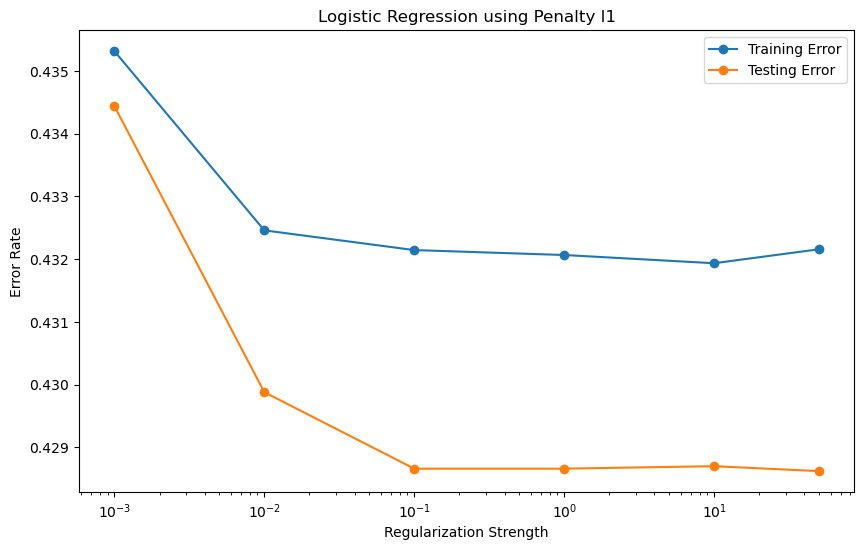

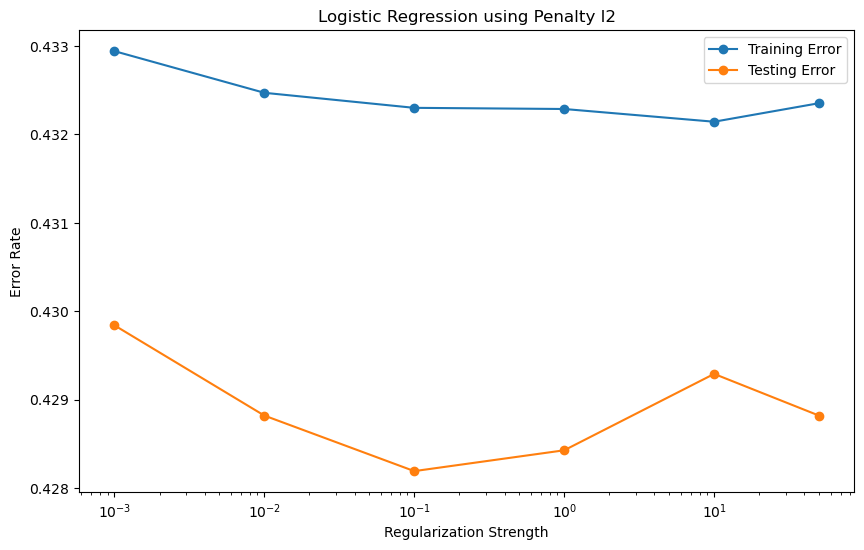

In [60]:
#LOGISTIC REGRESSION

train_errors_l1 = []
test_errors_l1 = []

train_errors_l2 = []
test_errors_l2 = []

# hyperparameters to test
regularization_values = [0.001, 0.01, 0.1, 1, 10, 50]
penalty_values = ['l1', 'l2']

# testing different regularization values
for C in regularization_values:
    for penalty in penalty_values:
        logistic_model = LogisticRegression(C=C, penalty=penalty, solver='liblinear', fit_intercept=True)
        logistic_model.fit(X_train, y_train)

        if penalty == 'l1':
            train_errors_l1.append(1 - logistic_model.score(X_train, y_train))
            test_errors_l1.append(1 - logistic_model.score(X_test, y_test))

        else:
            train_errors_l2.append(1 - logistic_model.score(X_train, y_train))
            test_errors_l2.append(1 - logistic_model.score(X_test, y_test))

# plot regularization errors
plt.figure(figsize=(10, 6))
plt.semilogx(regularization_values, train_errors_l1, marker='o', label='Training Error')
plt.semilogx(regularization_values, test_errors_l1, marker='o', label='Testing Error')
plt.xlabel('Regularization Strength')
plt.ylabel('Error Rate')
plt.title('Logistic Regression using Penalty l1')
plt.legend()
plt.show()

# plot regularization errors
plt.figure(figsize=(10, 6))
plt.semilogx(regularization_values, train_errors_l2, marker='o', label='Training Error')
plt.semilogx(regularization_values, test_errors_l2, marker='o', label='Testing Error')
plt.xlabel('Regularization Strength')
plt.ylabel('Error Rate')
plt.title('Logistic Regression using Penalty l2')
plt.legend()
plt.show()

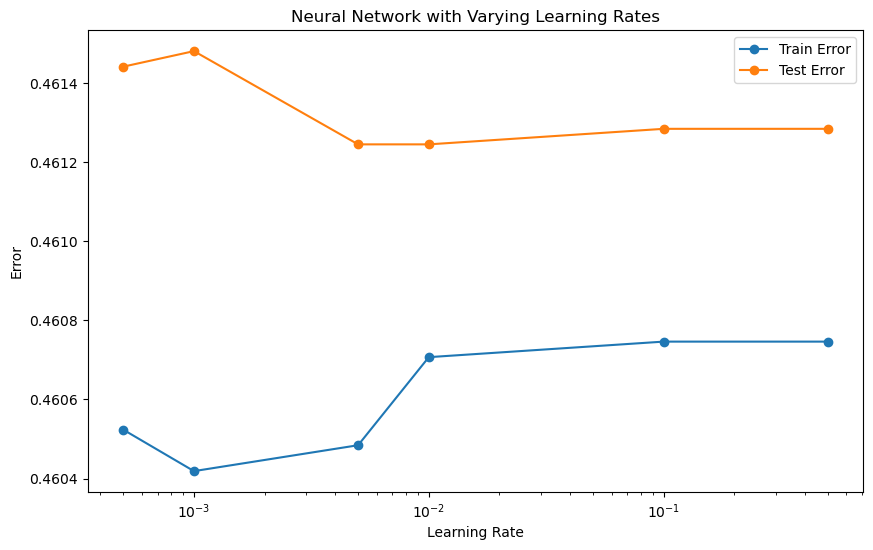

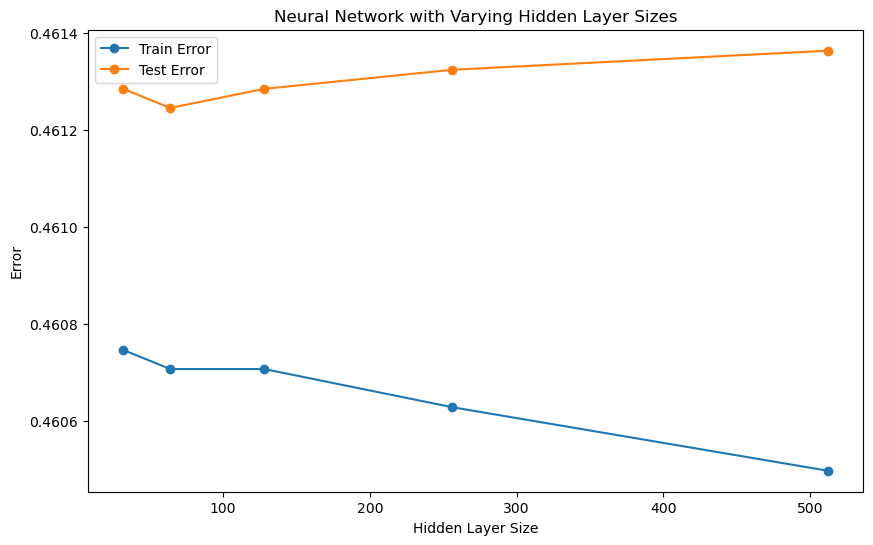

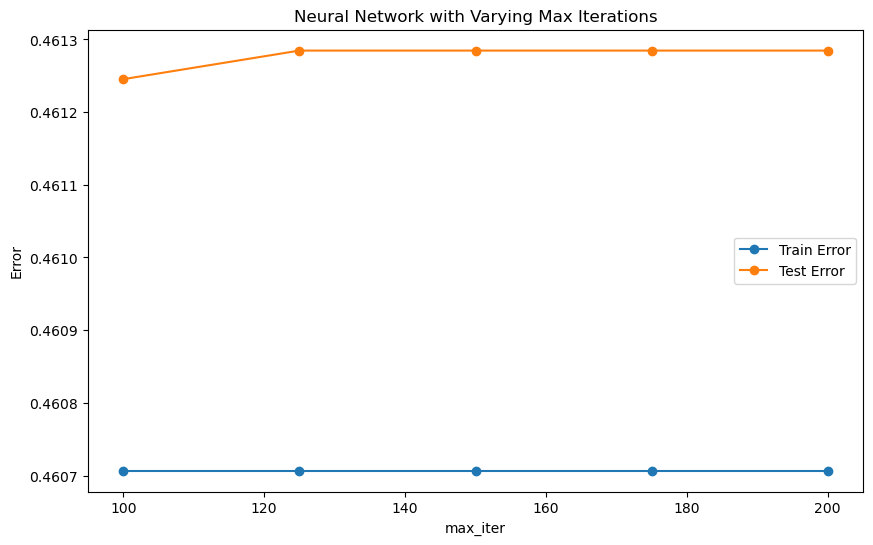

In [64]:
#Neural Network
learning_rates = [0.0005, 0.001, 0.005, 0.01, 0.1, 0.5]
hidden_layer_sizes = [32, 64, 128, 256, 512]
max_iters = [100, 125, 150, 175, 200]

training_errors_lr = []
testing_errors_lr = []

training_errors_hls = []
testing_errors_hls = []

training_errors_mi = []
testing_errors_mi = []

for lr in learning_rates:
    mlp = MLPClassifier(hidden_layer_sizes=(64),  activation='relu', solver='sgd',
                        learning_rate='constant', learning_rate_init=lr, random_state=seed,
                        batch_size=256, max_iter=100, n_iter_no_change=100)
    
    mlp.fit(X_train, y_train)

    training_errors_lr.append(1 - mlp.score(X_train, y_train))
    testing_errors_lr.append(1 - mlp.score(X_test, y_test))

for hidden_layer in hidden_layer_sizes:
    mlp = MLPClassifier(hidden_layer_sizes=(hidden_layer),  activation='relu', solver='sgd',
                        learning_rate='constant', learning_rate_init=0.01, random_state=seed,
                        batch_size=256, max_iter=100, n_iter_no_change=100)
    
    mlp.fit(X_train, y_train)

    training_errors_hls.append(1 - mlp.score(X_train, y_train))
    testing_errors_hls.append(1 - mlp.score(X_test, y_test))


for max_iter in max_iters:
    mlp = MLPClassifier(hidden_layer_sizes=(64),  activation='relu', solver='sgd',
                        learning_rate='constant', learning_rate_init=0.01, random_state=seed,
                        batch_size=256, max_iter=max_iter, n_iter_no_change=100)
    
    mlp.fit(X_train, y_train)

    training_errors_mi.append(1 - mlp.score(X_train, y_train))
    testing_errors_mi.append(1 - mlp.score(X_test, y_test))
    

# plot learning rate errors
plt.figure(figsize=(10, 6))
plt.semilogx(learning_rates, training_errors_lr, marker='o', label='Train Error')
plt.semilogx(learning_rates, testing_errors_lr, marker='o', label='Test Error')
plt.xlabel('Learning Rate')
plt.ylabel('Error')
plt.title('Neural Network with Varying Learning Rates')
plt.legend()
plt.show()


# plot hidden_layer_sizes errors
plt.figure(figsize=(10, 6))
plt.plot(hidden_layer_sizes, training_errors_hls, marker='o', label='Train Error')
plt.plot(hidden_layer_sizes, testing_errors_hls, marker='o', label='Test Error')
plt.xlabel('Hidden Layer Size')
plt.ylabel('Error')
plt.title('Neural Network with Varying Hidden Layer Sizes')
plt.legend()
plt.show()

# plot max_iters errors
plt.figure(figsize=(10, 6))
plt.plot(max_iters, training_errors_mi, marker='o', label='Train Error')
plt.plot(max_iters, testing_errors_mi, marker='o', label='Test Error')
plt.xlabel('max_iter')
plt.ylabel('Error')
plt.title('Neural Network with Varying Max Iterations')
plt.legend()
plt.show()

